    problem  search  expansions  tests  new nodes  plan length        time  \
0         1       1          43     56        180            6    0.024007   
1         1       2        1458   1459       5960            6    0.613613   
2         1       3          12     13         48           12    0.005627   
3         1       4         101    271        414           50    0.075467   
4         1       5          55     57        224            6    0.026934   
5         1       6        4229   4230      17029            6    1.855552   
6         1       7           7      9         28            6    0.004607   
7         1       8          55     57        224            6    0.027084   
8         1       9          41     43        170            6    0.035907   
9         1      10          11     13         50            6    1.581331   
10        2       1        3343   4609      30509            9    9.868374   
11        2       2           0      0          0            0  

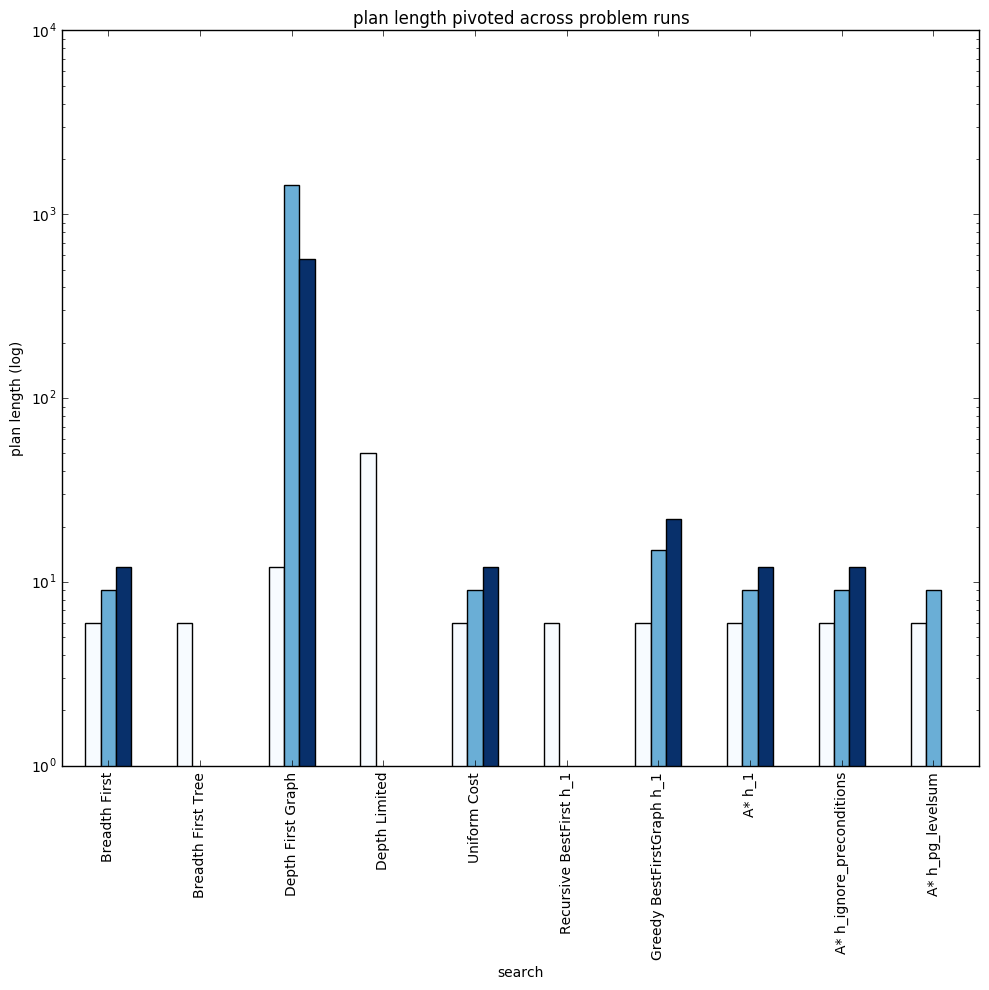

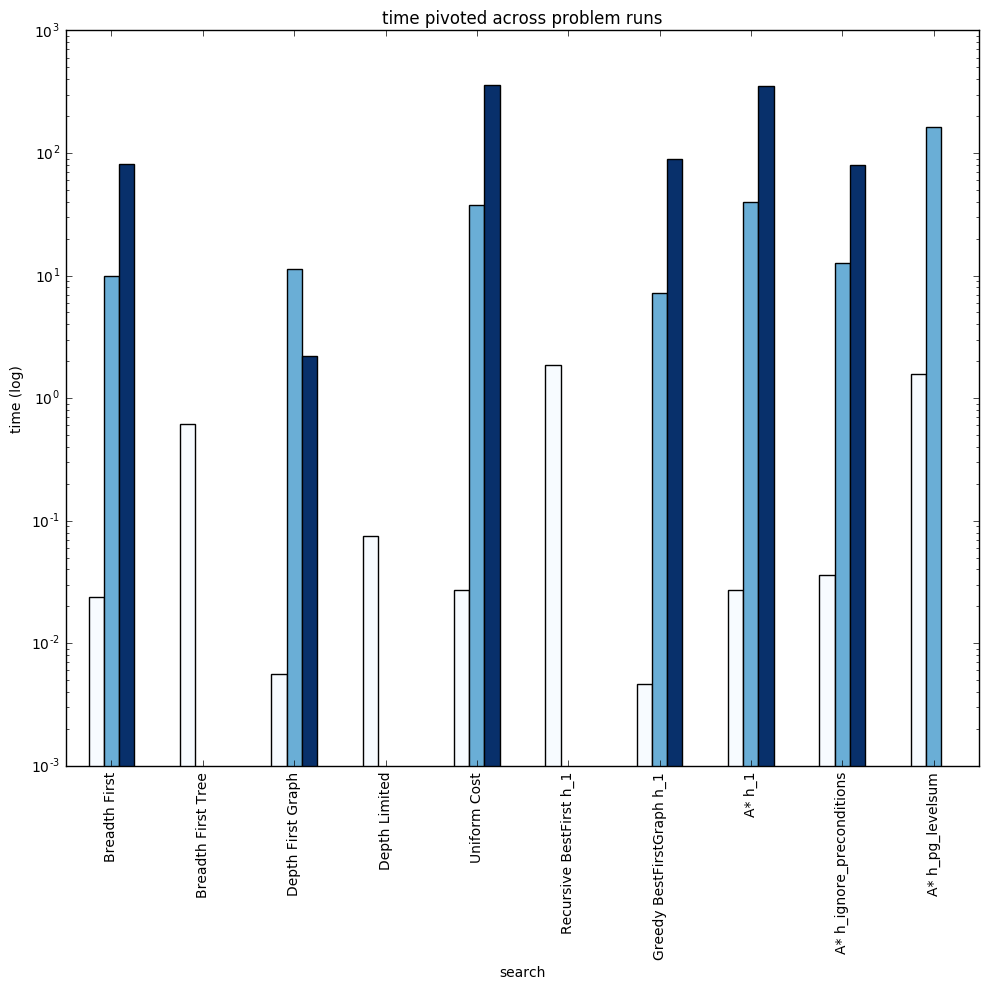

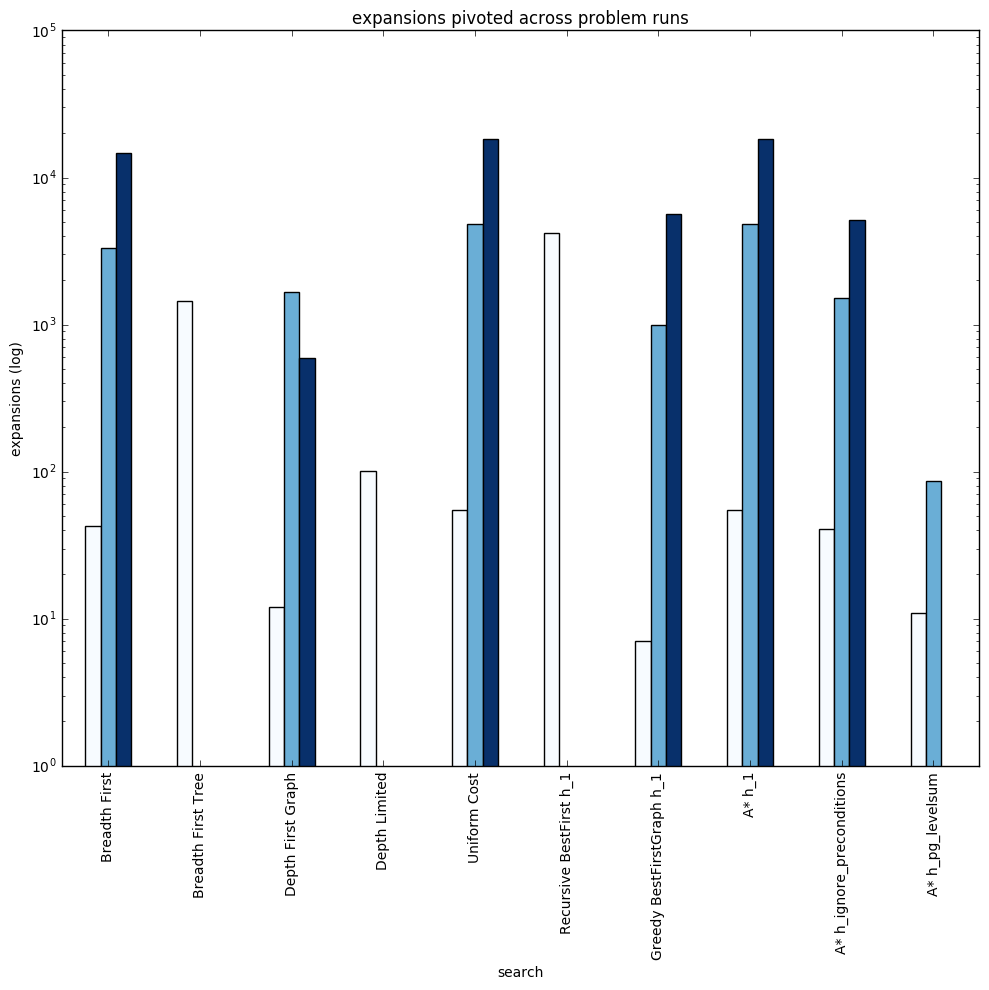

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


search_map = {
    1: 'Breadth First',
    2: 'Breadth First Tree',
    3: 'Depth First Graph',
    4: 'Depth Limited',
    5: 'Uniform Cost',
    6: 'Recursive BestFirst h_1',
    7: 'Greedy BestFirstGraph h_1',
    8: 'A* h_1',
    9: 'A* h_ignore_preconditions',
    10: 'A* h_pg_levelsum'
}



df=pd.read_csv('uninformed.csv')
df['search_name'] = df['search'].map(search_map)
print(df)

labels = []
idx=1

for y in ['plan length', 'time', 'expansions']:
    a = df.pivot(index='search', columns='problem', values=y).plot(kind='bar', logy=True, legend=False, figsize=(10,10), colormap='Blues')
    a.set_ylabel(y+" (log)")
    a.set_title(y+" pivoted across problem runs")
    a.set_xticks(range(10))
    a.set_xticklabels(df.search_name, rotation=90)
    fig = a.get_figure()
    plt.tight_layout()
    fig.savefig("img_{}.png".format(y.replace(' ','_')))
plt.show()

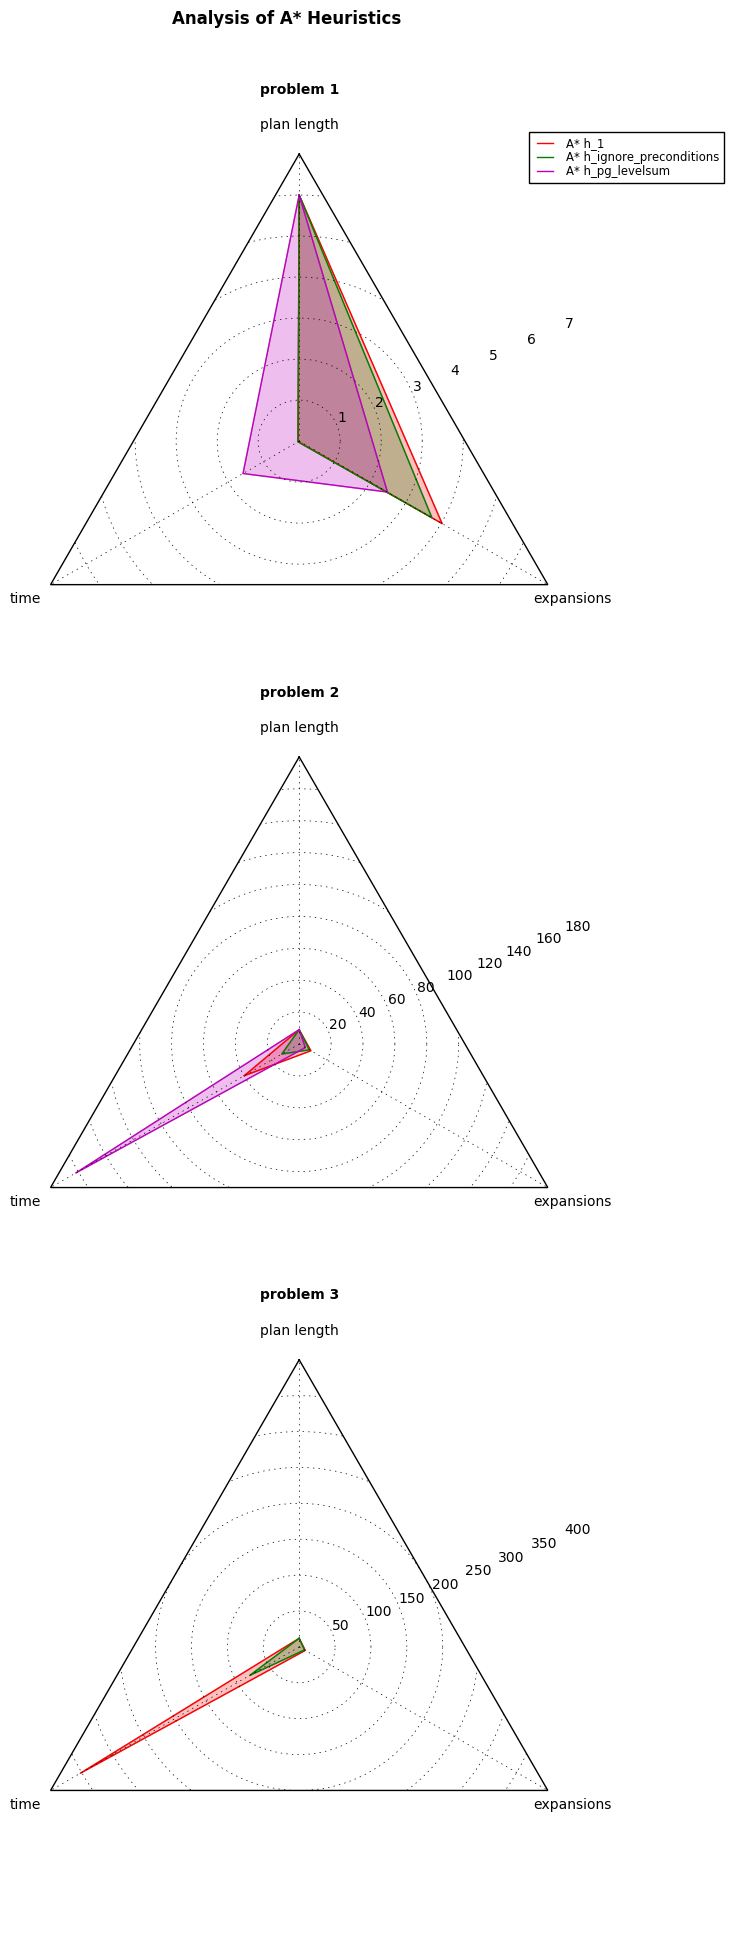

In [6]:
"""
======================================
Radar chart (aka spider or star chart)
======================================

This example creates a radar chart, also known as a spider or star chart [1]_.

Although this example allows a frame of either 'circle' or 'polygon', polygon
frames don't have proper gridlines (the lines are circles instead of polygons).
It's possible to get a polygon grid by setting GRIDLINE_INTERPOLATION_STEPS in
matplotlib.axis to the desired number of vertices, but the orientation of the
polygon is not aligned with the radial axes.

.. [1] http://en.wikipedia.org/wiki/Radar_chart
"""
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts


N = 3
theta = radar_factory(N, frame='polygon')
spoke_labels = ['plan length', 'time', 'expansions']
fig, axes = plt.subplots(figsize=(10, 20), nrows=3, ncols=1,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.90, bottom=0.01)

colors = ['r', 'g', 'm']
for ax, problem in zip(axes.flatten(), (1, 2, 3)):
    #ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title("problem {}".format(problem), weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    problem_data = df[df["problem"] == problem]
    problem_data = problem_data[problem_data["search"].isin([8,9,10])]
    problem_data['expansions'] += 1
    problem_data['expansions'] = np.log(problem_data.expansions)

    problem_data = problem_data[spoke_labels]
    
    pdata=[]
    for row in problem_data.iterrows():
        index, data = row
        data += 0.0001
        pdata.append(data.tolist())
    for d, color in zip(pdata, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
ax = axes[0]
labels = ('A* h_1', 'A* h_ignore_preconditions', 'A* h_pg_levelsum')
legend = ax.legend(labels, loc=(0.9, .95),
                   labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, 'Analysis of A* Heuristics',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

plt.show()